<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Цель проекта** : Построить модель для задачи классификации, которая определит расторгнет клиент договор или нет. 


**Ход проекта**:
    
 1. Подготовка данных. 
   - Изучение информации.
   - Нормализация данных.
 2. Исследование задачи.
   - Разделение данных на выборки.
   - Кодирование данных.
   - Масштабирование данных.
   - Подбор подходящей модели.
   - Исследование балансов классов.
 3. Борьба с дисбалансом. 
   - Подбор оптимального метода.
   - Вычисление f1-меры.
   - Измерение AUC-ROC.
 4. Тестирование модели. 

## Подготовка данных

Загрузим необходимые инструменты.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

Откроем файл и изучим данные.

In [2]:
df = pd.read_csv('./отток клиентов.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

В датафрейме есть столбцы, которые никак не влияют на обучение модели, это RowNumber, CustomerId и Surname. Их можно удалить. В столбце Tenure есть NaN значения, заменим их на 0.

In [5]:
data = df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)

In [6]:
data['Tenure'] = data['Tenure'].fillna(0)

## Исследование задачи

В исходных данных много категориальных признаков, преобразуем их в численные техникой прямого кодирования ОНЕ. Чтобы не попасть в дамми-ловушку, используем аргумент drop_first.

In [7]:
data_ohe = pd.get_dummies(data, drop_first=True)

После кодирования можно поделить данные на три выборки: обучающую, валидационную и тестовую, в пропорции 3:1:1. Для этого сначала отделим 60% обучающей выборки, а затем разобьем оставшиеся 40% пополам, на валидационную и тестовую.

In [8]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

In [9]:
features_train, features_1, target_train, target_1 = train_test_split(features, target, test_size=0.4,
                                                                     random_state=12345)

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(features_1, target_1, test_size=0.5,
                                                                           random_state=12345)

In [11]:
print(target_train.count()) # проверим результаты разделения
print(target_valid.count())
print(target_test.count())

6000
2000
2000


In [12]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


В разных столбцах разные численные значения, нужно привести их к общему масштабу.

In [13]:
numeric = data_ohe.columns.drop('Exited')

In [14]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Посмотрим какая модель дает лучший результат на примере метрики accuracy.

In [15]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
accuracy_valid

0.802

In [16]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
accuracy_valid

0.7865

In [17]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
accuracy_valid

0.858

Самое высокое значение у случайного леса. Попробуем подобрать гиперпараметры, чтобы найти лучшую модель.

In [18]:
best_model=None
best_result=0
for est in range(10, 100, 10):
    for depth in range(1, 20, 1):
        model = RandomForestClassifier(n_estimators=est, 
        max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predicted_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
print(best_model)
print(best_result)
print(best_est)
print(best_depth)

RandomForestClassifier(max_depth=12, n_estimators=40, random_state=12345)
0.865
40
12


Лучший показатель у модели с количеством деревьев 40 и глубиной дерева 12.

In [19]:
model = RandomForestClassifier(n_estimators=40, 
    max_depth=12, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
accuracy_valid

0.865

Проверим эту же метрику для константной модели.

In [20]:
model = DummyClassifier(random_state=12345)
model.fit(features_train, target_train)
target_pred_constant = pd.Series(model.predict(features_valid))
accuracy_score(target_valid, target_pred_constant)

0.791

accuracy константной модели 0.791, accuracy нашей модели 0.865. При такой метрике константной модели сложно судить об адекватности выбранной нами. Проверим баланс данных.

In [21]:
class_balance = data_ohe['Exited'].value_counts(normalize= True)
class_balance

0    0.7963
1    0.2037
Name: Exited, dtype: float64

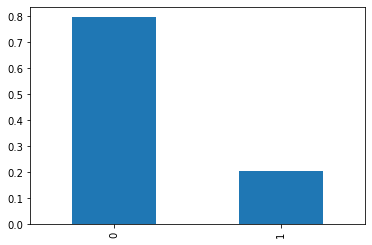

In [22]:
class_balance.plot(kind='bar');

В данных обнаружен дисбаланс. Нолей 0.7963, единиц 0.2037. Посмотрим что получается в предсказанных данных.

In [23]:
predicted_valid = pd.Series(model.predict(features_valid))

In [24]:
class_predicted = predicted_valid.value_counts(normalize=True)
class_predicted

0    1.0
dtype: float64

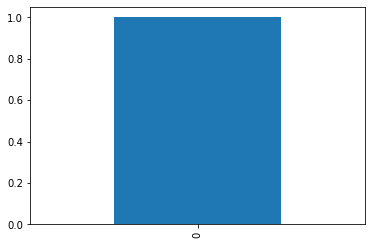

In [25]:
class_predicted.plot(kind='bar');

In [26]:
confusion_matrix(target_valid, predicted_valid)

array([[1582,    0],
       [ 418,    0]], dtype=int64)

In [27]:
f1_score(target_valid, predicted_valid)

0.0

Из-за силного дисбаланса, модель предсказывает только ноли. Модель нельзя считать адекватной.

## Борьба с дисбалансом

Прежде чем обучать модель, нужно сбалансировать данные. Попробуем выбрать оптимальный метод.

In [28]:
def auc_roc_graph(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')    # функция строит графики ROC-кривой
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [29]:
def model_check(model, features_valid, target_valid):
    probabilities_valid = model.predict_proba(features_valid) 
    predict_valid = model.predict(features_valid)
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])   # функция вычисляет метрики auc_roc и f1
    auc_roc_graph(fpr, tpr)
    auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
    f1 = f1_score(target_valid, predict_valid)
    return auc_roc, f1

Метод взвешивания классов. Протестируем все три модели.

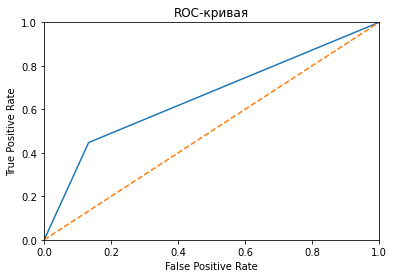

0.6573125291103866
0.4588957055214724


In [30]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
auc_roc, f1 = model_check(model, features_valid, target_valid) 
print(auc_roc)
print(f1)

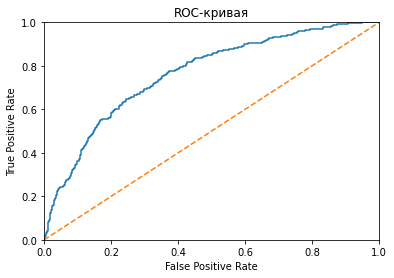

0.7633680944114107
0.4888888888888888


In [31]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
auc_roc, f1 = model_check(model, features_valid, target_valid)
print(auc_roc)
print(f1)

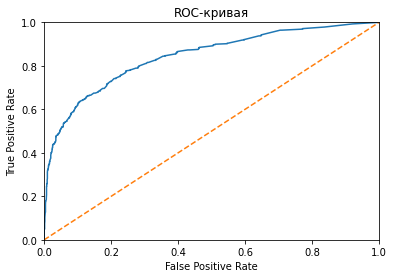

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=90,
                       random_state=12345)
0.8569508042027837
0.6365638766519824
90
8


In [32]:
auc_roc=0
f1_best=0
for est in range(10, 100, 10):
    for depth in range(1, 20, 1):
        model = RandomForestClassifier(n_estimators=est, 
        max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        probabilities_valid = model.predict_proba(features_valid) 
        predict_valid = model.predict(features_valid)
        fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])
        auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
        f1 = f1_score(target_valid, predict_valid)
        if f1 > f1_best:
            best_model = model
            f1_best = f1
            auc_roc_best = auc_roc
            best_est = est
            best_depth = depth
auc_roc_graph(fpr, tpr)                
print(best_model)
print(auc_roc_best)
print(f1_best)
print(best_est)
print(best_depth)

У модели случайного леса по-прежнему самые лучшие показатели. Новые гиперпараметры: глубина дерева - 8, количество - 50.

Теперь попробуем увеличить выборку. Также посмотрим все три модели.

In [33]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [34]:
target_upsampled.value_counts() # проверим баланс после балансировки


0    4804
1    4784
Name: Exited, dtype: int64

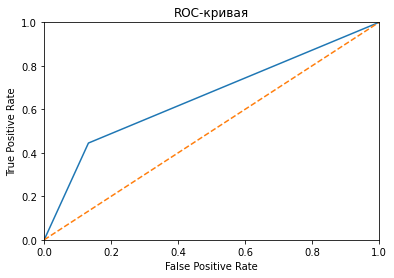

0.6564324124873728
0.4575645756457565


In [35]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
auc_roc, f1 = model_check(model, features_valid, target_valid)
print(auc_roc)
print(f1)

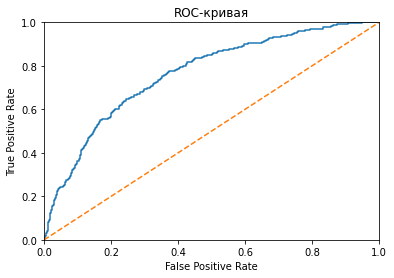

0.7633771677786582
0.4888888888888888


In [36]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
auc_roc, f1 = model_check(model, features_valid, target_valid)
print(auc_roc)
print(f1)

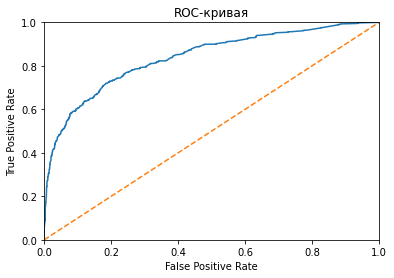

RandomForestClassifier(max_depth=13, n_estimators=60, random_state=12345)
0.8446949533931369
0.626829268292683
60
13


In [37]:
auc_roc=0
f1_best=0
for est in range(10, 100, 10):
    for depth in range(1, 20, 1):
        model = RandomForestClassifier(n_estimators=est, 
        max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        probabilities_valid = model.predict_proba(features_valid) 
        predict_valid = model.predict(features_valid)
        fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])
        auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
        f1 = f1_score(target_valid, predict_valid)
        if f1 > f1_best:
            best_model = model
            f1_best = f1
            auc_roc_best = auc_roc
            best_est = est
            best_depth = depth
auc_roc_graph(fpr, tpr)                
print(best_model)
print(auc_roc_best)
print(f1_best)
print(best_est)
print(best_depth)

И тут тоже лидирует случайный лес. В целом после балансировки этим методом цифры поменялись незначительно.

Остался последний метод. Уменьшение выборки.

In [38]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)



In [39]:
target_downsampled.value_counts() # проверим баланс после балансировки

0    1201
1    1196
Name: Exited, dtype: int64

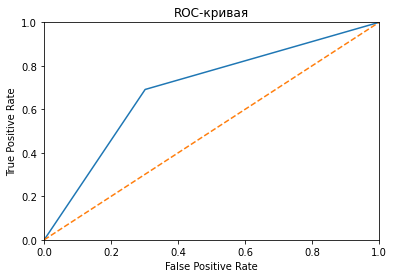

0.6949352464024099
0.48817567567567566


In [40]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_downsampled, target_downsampled)
auc_roc, f1 = model_check(model, features_valid, target_valid)
print(auc_roc)
print(f1)

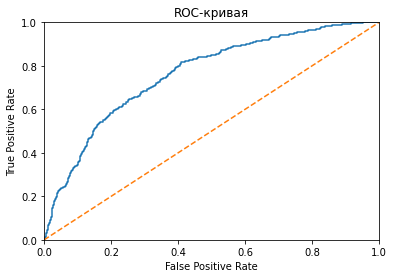

0.7623443161403105
0.4888507718696398


In [41]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
auc_roc, f1 = model_check(model, features_valid, target_valid)
print(auc_roc)
print(f1)

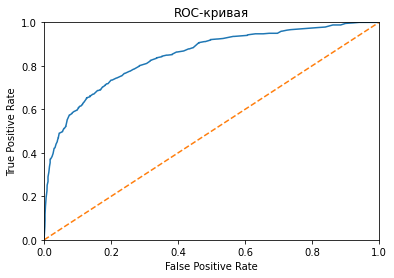

RandomForestClassifier(max_depth=4, n_estimators=10, random_state=12345)
0.835229163012116
0.6036217303822937
10
4


In [42]:
auc_roc=0
f1_best=0
for est in range(10, 100, 10):
    for depth in range(1, 20, 1):
        model = RandomForestClassifier(n_estimators=est, 
        max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        probabilities_valid = model.predict_proba(features_valid) 
        predict_valid = model.predict(features_valid)
        fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])
        auc_roc = roc_auc_score(target_valid, probabilities_valid[:, 1])
        f1 = f1_score(target_valid, predict_valid)
        if f1 > f1_best:
            best_model = model
            f1_best = f1
            auc_roc_best = auc_roc
            best_est = est
            best_depth = depth
auc_roc_graph(fpr, tpr)                
print(best_model)
print(auc_roc_best)
print(f1_best)
print(best_est)
print(best_depth)

Тут та же картина. Лучше всего себя показывает случайный лес, а в целом колебания метрик в пределах сотых. Таким образом лучшей моделью можно признать случайный лес, а лучшим способом балансировки - взвешивание классов, при этом методе показатель метрики  f1-score составил 0.631236442516269. Это наивысшее значение, которое нам улалось получить. AUC-ROC также выше у случайного леса, однако в процессе балансировки эта метрика почти не изменялась.

## Тестирование модели

Теперь протестируем нашу модель на тестовой выборке.

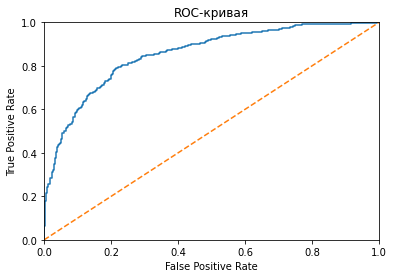

0.8537502005033948
0.6137339055793991


In [43]:
model = RandomForestClassifier(n_estimators=50, 
    max_depth=8, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
probabilities_test = model.predict_proba(features_test)
predict_test = model.predict(features_test)
auc_roc, f1 = model_check(model, features_test, target_test)
print(auc_roc)
print(f1)

 При финальном тестировании модель показала хорошие результаты. Метрика AUC-ROC получилась на 2 тысячных ниже, чем при тестировании на валидационной выборке, а метрика f1 меньше на 3 сотых. Такую разницу можно считать незначительной, задача выполнена.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*

**Вывод**:
 В ходе работы были построены и обучены три модели трех разных структур: дерево решений, случайный лес и логистическая регрессия. Путем перебора были подобраны гиперпараметры, которые дали наилучший результат. Также был выявлен дисбаланс данных и опробованы различные методы борьбы с ним. Лучшим способом оказалось взвешивание классов. Все три модели при этом виде балансировки показали хорошие результаты. 
 
 Получилось следующее:
1. Модель DecisionTreeClassifier, AUC-ROC = 0.6555522958643591, f1 = 0.45622688039457454.
2. Модель LogisticRegression, AUC-ROC = 0.7633680944114107, f1 = 0.4888888888888888.
3. Модель RandomForestClassifier(max_depth=10, n_estimators=100), AUC-ROC = 0.8544722627163244, f1 = 0.631236442516269.

Таким образом мы видим, что наилучшие показатели у модели под номером 3. Модель RandomForestClassifier, с гиперпараметрами глубина дерева 8 и количеством деревьев 50. Тестирование на тестовой выборке показало похожие результаты. AUC-ROC = 0.8520922060770143, а1 = 0.6079484425349088. f1-мера больше 0.59. Цель работы выполнена.  